(3000, 85)
(300, 10, 85)


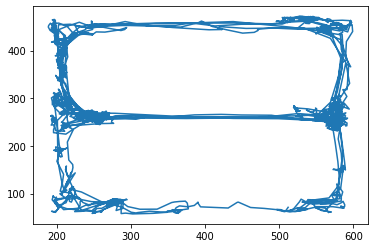

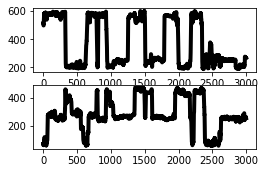

In [1]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt 
from model import VRNN
import scipy.io
import numpy as np
all_time =3000
Time = 10
neuron_num = 85
datax = scipy.io.loadmat("spike85_k09_6000.mat")
y_data = datax["spike85_k09_6000"][:,:all_time].T
traj = scipy.io.loadmat("trj85_k09_6000.mat")
traj = traj["trj85_k09_6000"][:,:all_time].T
factor_dim = 2

NRep=int(all_time/Time)
output = np.zeros((NRep,Time,neuron_num))
print(y_data.shape)
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output.shape)
BATCH_SIZE = 10

Train Epoch: 1 [0/296 (0%)]	 KLD Loss: 0.053304 	 NLL Loss: 735.425110


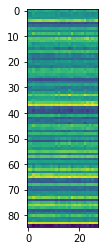

====> Epoch: 1 Average loss: 583.0201
Saved model to saves/vrnn_state_dict_1.pth


In [4]:
def train(epoch):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        #print(data.shape)
        #transforming data
        data = data.to(device)
        data = data.squeeze().transpose(0, 1) # (seq, batch, elem)
        data = (data - data.min()) / (data.max() - data.min())
        #print(data.shape)
        #forward + backward + optimize
        optimizer.zero_grad()
        kld_loss, nll_loss, _, _, _ = model(data)
        loss = kld_loss + nll_loss
        loss.backward()
        optimizer.step()

        #grad norm clipping, only in pytorch version >= 1.10
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        #printing
        if batch_idx % print_every == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, batch_size * (len(train_loader.dataset)//batch_size),
                100. * batch_idx / len(train_loader),
                kld_loss / batch_size,
                nll_loss / batch_size))
            
            sample = model.sample(torch.tensor(28, device=device))
            plt.imshow(sample.to(torch.device('cpu')).numpy().T)
            plt.pause(1e-6)

        train_loss += loss.item()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    

def test():

    mean_kld_loss, mean_nll_loss = 0, 0
    all_trj_infer = np.zeros((all_time,2))
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):                                           

            data = data.to(device)
            data = data.squeeze().transpose(0, 1)
            data = (data - data.min()) / (data.max() - data.min())
            #print("i",batch_idx,data.shape)
            kld_loss, nll_loss, _, _, trj_infer = model(data)
            mean_kld_loss += kld_loss.item()
            mean_nll_loss += nll_loss.item()
            #print("E",trj_infer[0].shape)
            # batch_size must be all_time % Time = 0
            for i in range(Time):
                for j in range(BATCH_SIZE):
                    all_trj_infer[BATCH_SIZE*i+j + batch_idx,:] = trj_infer[0][j]
    mean_kld_loss /= len(test_loader.dataset)
    mean_nll_loss /= len(test_loader.dataset)
    print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
        mean_kld_loss, mean_nll_loss))
    return all_trj_infer

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')

x_dim = 85
h_dim = 100
z_dim = 2
n_layers =  1
n_epochs = 1
clip = 10
learning_rate = 1e-4
batch_size = 8 #128
seed = 128
print_every = 1000 # batches
save_every = 10 # epochs

torch.manual_seed(seed)
plt.ion()

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, 
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

train_loader = torch.utils.data.DataLoader(output,batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(output,batch_size=BATCH_SIZE, shuffle=False)
print(train_loader)
model = VRNN(x_dim, h_dim, z_dim, n_layers)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, n_epochs + 1):
    train(epoch)
    #test(epoch)

    if epoch % save_every == 1:
        fn = 'saves/vrnn_state_dict_'+str(epoch)+'.pth'
        torch.save(model.state_dict(), fn)
        print('Saved model to '+fn)


i 0 torch.Size([10, 10, 85])
i 1 torch.Size([10, 10, 85])
i 2 torch.Size([10, 10, 85])
i 3 torch.Size([10, 10, 85])
i 4 torch.Size([10, 10, 85])
i 5 torch.Size([10, 10, 85])
i 6 torch.Size([10, 10, 85])
i 7 torch.Size([10, 10, 85])
i 8 torch.Size([10, 10, 85])
i 9 torch.Size([10, 10, 85])
i 10 torch.Size([10, 10, 85])
i 11 torch.Size([10, 10, 85])
i 12 torch.Size([10, 10, 85])
i 13 torch.Size([10, 10, 85])
i 14 torch.Size([10, 10, 85])
i 15 torch.Size([10, 10, 85])
i 16 torch.Size([10, 10, 85])
i 17 torch.Size([10, 10, 85])
i 18 torch.Size([10, 10, 85])
i 19 torch.Size([10, 10, 85])
i 20 torch.Size([10, 10, 85])
i 21 torch.Size([10, 10, 85])
i 22 torch.Size([10, 10, 85])
i 23 torch.Size([10, 10, 85])
i 24 torch.Size([10, 10, 85])
i 25 torch.Size([10, 10, 85])
i 26 torch.Size([10, 10, 85])
i 27 torch.Size([10, 10, 85])
i 28 torch.Size([10, 10, 85])
i 29 torch.Size([10, 10, 85])
====> Test set loss: KLD Loss = 0.0087, NLL Loss = 575.4908 
i 0 torch.Size([10, 10, 85])
i 1 torch.Size([10, 

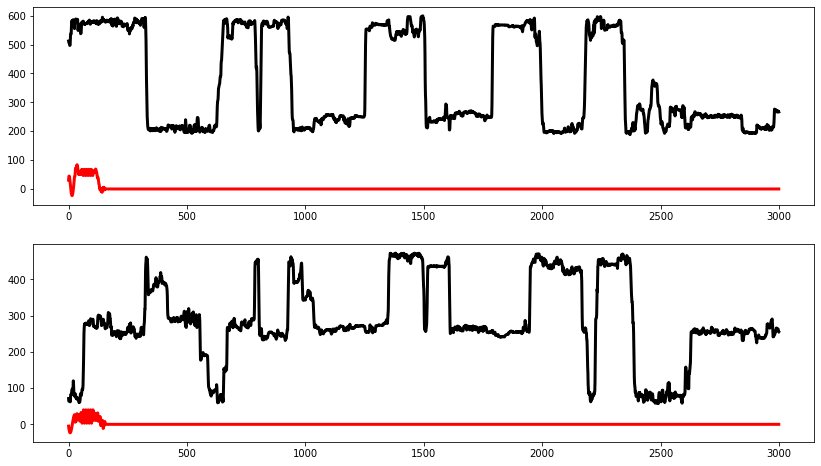

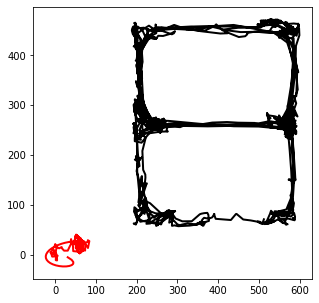

In [3]:
test()
import funs
qz_mean_est = test()
#plt.plot(qz_mean_est[:,0])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
#plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
z_true_c = traj# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')